In [2]:
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from tensorflow.keras.metrics import BinaryCrossentropy, BinaryAccuracy, Precision, Recall

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

import matplotlib.pyplot as plt

In [5]:
heart_attack_data = np.genfromtxt('heart.csv', delimiter=',')[1:]

heart_attack_data_train, heart_attack_data_test = train_test_split(heart_attack_data, train_size=0.8, test_size=0.2, random_state=1)
heart_attack_data_cv, heart_attack_data_test = train_test_split(heart_attack_data_test, train_size=0.5, test_size=0.5, random_state=1)

print('heart_attack_data_train | ', len(heart_attack_data_train))
print('heart_attack_data_cv    | ', len(heart_attack_data_cv))
print('heart_attack_data_test  | ', len(heart_attack_data_test))

heart_attack_data_train |  242
heart_attack_data_cv    |  30
heart_attack_data_test  |  31


In [7]:
amount_of_features = heart_attack_data.shape[1] - 1

X_train = heart_attack_data_train[:,:amount_of_features]
y_train = heart_attack_data_train[:,amount_of_features]

print('X_train | ', X_train.shape)
print('y_train | ',y_train.shape)
print()

X_cv = heart_attack_data_cv[:,:amount_of_features]
y_cv = heart_attack_data_cv[:,amount_of_features]

print('X_cv | ', X_cv.shape)
print('y_cv | ',y_cv.shape)
print()

X_test = heart_attack_data_test[:,:amount_of_features]
y_test = heart_attack_data_test[:,amount_of_features]

print('X_test | ', X_test.shape)
print('y_test | ',y_test.shape)
print()

X_train |  (242, 13)
y_train |  (242,)

X_cv |  (30, 13)
y_cv |  (30,)

X_test |  (31, 13)
y_test |  (31,)



In [22]:
def build_model(X, y, degree = 2, _lambda = 0.01, epochs=1000):
    poly_features = PolynomialFeatures(degree=degree)
    features_poly = poly_features.fit_transform(X)

    model = Sequential(
    [
        Dense(25, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(_lambda)),
        Dense(25, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(_lambda)),
        Dense(1, activation='sigmoid')
    ]
    )

    model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
    )

    model.fit(
        features_poly,y,            
        epochs=epochs,
    )

    return model, poly_features

In [ ]:
max_degree = 7
loss_degree_train = np.zeros(max_degree)
loss_degree_cv = np.zeros(max_degree)

for degree in range(max_degree):
    model, poly_features = build_model(X_train, y_train, degree+1)

    loss_object = BinaryCrossentropy()

    prediction_train = np.reshape(model.predict(poly_features.fit_transform(X_train)), -1)
    loss_degree_train[degree] = loss_object(y_train, prediction_train).numpy()

    prediction_cv = np.reshape(model.predict(poly_features.fit_transform(X_cv)), -1)
    loss_degree_cv[degree] = loss_object(y_cv, prediction_cv).numpy()

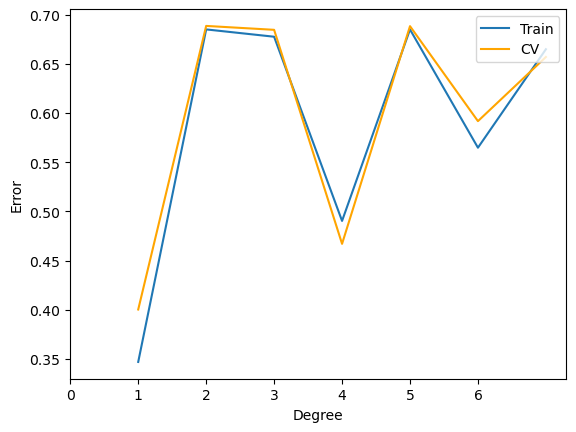

In [12]:
fig, ax = plt.subplots()

ax.plot(range(1, max_degree + 1), loss_degree_train, label="Train") 
ax.plot(range(1, max_degree + 1), loss_degree_cv, c='orange', label="CV") 
ax.set_xticks(range(max_degree))

ax.set_xlabel('Degree')
ax.set_ylabel('Error')

leg = plt.legend(loc='upper right')

Deegree 4 is good!

In [ ]:
degree = 4

lambda_range = np.array([0.0, 1e-6, 1e-5, 1e-4,1e-3,1e-2, 1e-1,1,10,100])

loss_train_regularization = np.zeros(len(lambda_range))
loss_cv_regularization = np.zeros(len(lambda_range))

for current_lambda_index in range(len(lambda_range)):
    model, poly_features = build_model(X_train, y_train, degree, lambda_range[current_lambda_index])

    loss_object = BinaryCrossentropy()

    prediction_train = np.reshape(model.predict(poly_features.fit_transform(X_train)), -1)
    loss_train_regularization[current_lambda_index] = loss_object(y_train, prediction_train).numpy()

    prediction_cv = np.reshape(model.predict(poly_features.fit_transform(X_cv)), -1)
    loss_cv_regularization[current_lambda_index] = loss_object(y_cv, prediction_cv).numpy()

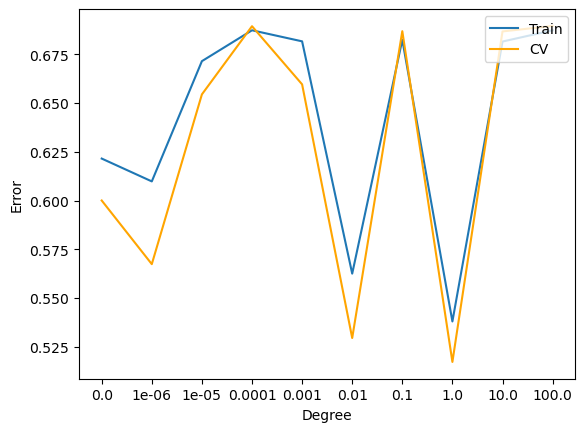

In [14]:
fig, ax = plt.subplots()

ax.plot(range(len(lambda_range)), loss_train_regularization, label="Train") 
ax.plot(range(len(lambda_range)), loss_cv_regularization, c='orange', label="CV") 
ax.set_xticks(range(len(lambda_range)), lambda_range)

ax.set_xlabel('Degree')
ax.set_ylabel('Error')

leg = plt.legend(loc='upper right')

Lambda 1.0 is good!

In [ ]:
model, poly_features = build_model(X_train, y_train, degree=4, _lambda=1.0, epochs=10000)

In [28]:
prediction_train = np.reshape(model.predict(poly_features.fit_transform(X_train)), -1)
accuracy_train = BinaryAccuracy()
accuracy_train.update_state(y_train, prediction_train)
accuracy_value = accuracy_train.result().numpy()
accuracy_percentage = accuracy_value * 100.0
print("Accuracy train: {:.2f}%".format(accuracy_percentage))


accuracy_cv = BinaryAccuracy()
prediction_cv = np.reshape(model.predict(poly_features.fit_transform(X_cv)), -1)
accuracy_cv.update_state(y_cv, prediction_cv)
accuracy_value = accuracy_cv.result().numpy()
accuracy_percentage = accuracy_value * 100.0
print("Accuracy cv: {:.2f}%".format(accuracy_percentage))

accuracy_test = BinaryAccuracy()
prediction_test = np.reshape(model.predict(poly_features.fit_transform(X_test)), -1)
accuracy_test.update_state(y_test, prediction_test)
accuracy_value = accuracy_test.result().numpy()
accuracy_percentage = accuracy_value * 100.0
print("Accuracy test: {:.2f}%".format(accuracy_percentage))

8/8 [==============================] - 0s 699us/step
Accuracy train: 55.37%
1/1 [==============================] - 0s 14ms/step
Accuracy cv: 53.33%
1/1 [==============================] - 0s 15ms/step
Accuracy test: 48.39%
